In [29]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sys
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
sys.path.append('../src')
from utils.load_data import load_metadata, load_trial
from preprocessing.preprocessing import preprocess_deep_learning,preprocess_time_domain,preprocess_frequency_domain,preprocess_and_epoch_trial
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

In [30]:
base_path = '../data'
metadata = load_metadata(base_path)
train_df = metadata['train']
validation_df = metadata['validation']
test_df = metadata['test']
train_df.head()

,id,subject_id,task,trial_session,trial,label
0,1,S1,MI,1,1,Left
1,2,S1,MI,1,2,Right
2,3,S1,MI,1,3,Left
3,4,S1,MI,1,4,Left
4,5,S1,MI,1,5,Left


In [58]:
target_len = 500
n_channels = 8

# Filter for subject S1
train_s1_df = train_df[train_df['subject_id'] == 'S1']

train_trials = []
train_labels = []

# Loop over all trials for S1
for idx, row in train_s1_df.iterrows():
    try:
        trial_df = load_trial(row, 'train', base_path)

        # Run the full preprocessing and epoching pipeline
        epochs, raw_resampled = preprocess_and_epoch_trial(trial_df)

        if epochs is None or len(epochs) == 0:
            continue

        # Average over epochs to get a fixed representation (channels x time)
        epoch_data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
        avg_epoch = np.mean(epoch_data, axis=0)  # shape: (n_channels, n_times)

        # Ensure the fixed shape
        if avg_epoch.shape[1] < target_len:
            avg_epoch = np.pad(avg_epoch, ((0, 0), (0, target_len - avg_epoch.shape[1])), mode='constant')
        else:
            avg_epoch = avg_epoch[:, :target_len]

        # Flatten and append
        trial_flat = avg_epoch.flatten()
        train_trials.append(trial_flat)
        train_labels.append(row['label'])

    except Exception as e:
        print(f"Error processing trial {row['id']}: {e}")

# Convert to array
X_train = np.stack(train_trials)
y_train = LabelEncoder().fit_transform(train_labels)

X_train.shape, np.unique(y_train)

Error processing trial 2401: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing trial 2402: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing trial 2403: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing trial 2404: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing trial 2405: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing trial 2406: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing trial 2407: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing trial 2408: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing trial 2409: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing trial 2410: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing trial 2411: tmax (8) must be less than or equal to the max time

((80, 8000), array([0, 1], dtype=int64))

In [57]:
val_trials = []
val_labels = []

# Loop over all trials in validation set
for idx, row in validation_df.iterrows():
    try:
        trial_df = load_trial(row, 'validation', base_path)

        # Run the full preprocessing and epoching pipeline
        epochs, raw_resampled = preprocess_and_epoch_trial(trial_df)

        if epochs is None or len(epochs) == 0:
            continue

        # Average over epochs to get a fixed representation (channels x time)
        epoch_data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
        avg_epoch = np.mean(epoch_data, axis=0)  # shape: (n_channels, n_times)

        # Ensure fixed shape by padding or trimming
        if avg_epoch.shape[1] < target_len:
            avg_epoch = np.pad(avg_epoch, ((0, 0), (0, target_len - avg_epoch.shape[1])), mode='constant')
        else:
            avg_epoch = avg_epoch[:, :target_len]

        # Flatten and append
        trial_flat = avg_epoch.flatten()
        val_trials.append(trial_flat)
        val_labels.append(row['label'])

    except Exception as e:
        print(f"Error processing validation trial {row['id']}: {e}")

# Final conversion using np.array (not flattening the full array!)
X_val = np.array(val_trials)
y_val = LabelEncoder().fit_transform(val_labels)

print(f'Validation shape: {X_val.shape}, Labels: {np.unique(y_val)}')

c:\Users\PC\Desktop\EEG\eeg-signal-classification\notebooks\../src\preprocessing\preprocessing.py:858: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(
c:\Users\PC\Desktop\EEG\eeg-signal-classification\notebooks\../src\preprocessing\preprocessing.py:858: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(
c:\Users\PC\Desktop\EEG\eeg-signal-classification\notebooks\../src\preprocessing\preprocessing.py:858: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for 

Error processing validation trial 4851: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing validation trial 4852: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing validation trial 4853: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing validation trial 4854: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing validation trial 4855: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing validation trial 4856: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing validation trial 4857: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing validation trial 4858: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing validation trial 4859: tmax (8) must be less than or equal to the max time (6.9960 s)
Error processing validation trial 4860: tmax (8) must be less than or equ

SVM Accuracy: 0.5531914893617021
Classification Report:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        26
           1       0.00      0.00      0.00        21

    accuracy                           0.55        47
   macro avg       0.28      0.50      0.36        47
weighted avg       0.31      0.55      0.39        47



d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DS course Data\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


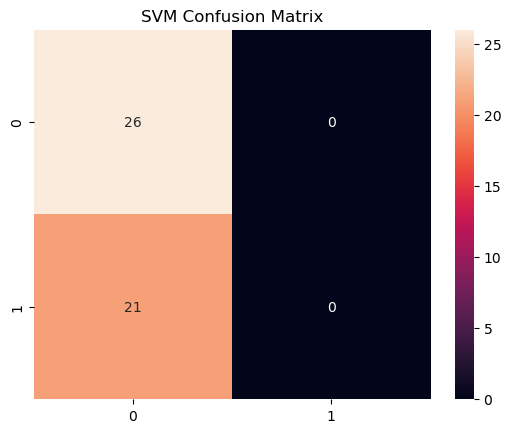

In [59]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_val)
print("SVM Accuracy:", accuracy_score(y_val, svm_preds))
print("Classification Report:\n", classification_report(y_val, svm_preds))
sns.heatmap(confusion_matrix(y_val, svm_preds), annot=True, fmt='d')
plt.title("SVM Confusion Matrix")
plt.show()


### Hybrid ELM model

In [ ]:
import numpy.linalg as LA

class ELMClassifier:
    def __init__(self, n_hidden=1000, activation='sigmoid'):
        self.n_hidden = n_hidden
        self.activation = activation

    def _activate(self, X):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-X))
        elif self.activation == 'tanh':
            return np.tanh(X)
        else:
            raise ValueError("Unsupported activation")

    def fit(self, X, y):
        self.input_weights = np.random.randn(X.shape[1], self.n_hidden)
        self.biases = np.random.randn(self.n_hidden)

        H = self._activate(np.dot(X, self.input_weights) + self.biases)
        self.output_weights = np.dot(LA.pinv(H), y)

    def predict(self, X):
        H = self._activate(np.dot(X, self.input_weights) + self.biases)
        raw_outputs = np.dot(H, self.output_weights)
        return np.round(raw_outputs).astype(int)


In [ ]:
elm = ELMClassifier(n_hidden=1000, activation='sigmoid')
elm.fit(X_train, y_train)
elm_preds = elm.predict(X_val)

print("ELM Accuracy:", accuracy_score(y_val, elm_preds))
print("Classification Report:\n", classification_report(y_val, elm_preds))
sns.heatmap(confusion_matrix(y_val, elm_preds), annot=True, fmt='d')
plt.title("ELM Confusion Matrix")
plt.show()


In [ ]:
# Hybrid ELM + SVM: Use ELM hidden layer as features for SVM
H_train = 1 / (1 + np.exp(-(np.dot(X_train, elm.input_weights) + elm.biases)))
H_val = 1 / (1 + np.exp(-(np.dot(X_val, elm.input_weights) + elm.biases)))

hybrid_svm = SVC(kernel='rbf')
hybrid_svm.fit(H_train, y_train)
hybrid_preds = hybrid_svm.predict(H_val)

print("Hybrid ELM + SVM Accuracy:", accuracy_score(y_val, hybrid_preds))
print("Classification Report:\n", classification_report(y_val, hybrid_preds))
sns.heatmap(confusion_matrix(y_val, hybrid_preds), annot=True, fmt='d')
plt.title("Hybrid ELM + SVM Confusion Matrix")
plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_val)

print("MLP Accuracy:", accuracy_score(y_val, mlp_preds))
print("Classification Report:\n", classification_report(y_val, mlp_preds))
sns.heatmap(confusion_matrix(y_val, mlp_preds), annot=True, fmt='d')
plt.title("MLP Confusion Matrix")
plt.show()


In [50]:
X_train_net = X_train.reshape(-1, n_channels, target_len, 1)
X_val_net = X_val.reshape(-1, n_channels, target_len, 1)